#### This notebook analyses the heat content and SST responses in the abrupt ACCESS-OM2 experiments.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Client Scheduler: tcp://127.0.0.1:36991 Dashboard: /proxy/34883/status,Cluster Workers: 8 Cores: 8 Memory: 128.85 GB


In [4]:
### Generate new session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

In [5]:
yr_beg = '2400-01-16'
yr_end = '2499-12-31'

expt = '1deg_jra55_ryf_cont'
var = 'temp'
frequency = '1 monthly'
temp_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end).chunk(chunks='auto') 

In [6]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp'
frequency = '1 monthly'
temp_cool = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [7]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp'
frequency = '1 monthly'
temp_warm = cc.querying.getvar(expt, var, session, frequency = frequency, end_time = yr_end).chunk(chunks='auto') 

In [8]:
expt = '1deg_jra55_ryf_RCPcool_humid_x2'
var = 'temp'
frequency = '1 monthly'
temp_cool_x2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [9]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
var = 'temp'
frequency = '1 monthly'
temp_RCPwarm_humid_x2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

### Global average temperature

In [7]:
yr_beg = '2400-02-01'
yr_end = '2499-12-31'

expt = '1deg_jra55_ryf_cont'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto') 

# [:-1] removes the snapshot at 2500-01-01 for annual avergae purposes

In [8]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cool = cc.querying.getvar(expt, var, session, frequency = frequency)[:-1].chunk(chunks='auto') 

In [9]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp_global_ave'
frequency = '1 daily'
gat_warm = cc.querying.getvar(expt, var, session, frequency = frequency)[:-1].chunk(chunks='auto') 

In [79]:
expt = '1deg_jra55_ryf_RCPcool_humid_x2'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cool_x2 = cc.querying.getvar(expt, var, session, frequency = frequency)[:-1].chunk(chunks='auto') 

In [80]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
var = 'temp_global_ave'
frequency = '1 daily'
gat_warm_x2 = cc.querying.getvar(expt, var, session, frequency = frequency)[:-1].chunk(chunks='auto') 

In [10]:
gat_cont = gat_cont.groupby('time.year').mean(dim='time').load()
gat_cool = gat_cool.groupby('time.year').mean(dim='time').load()
gat_warm = gat_warm.groupby('time.year').mean(dim='time').load()
# gat_cool_x2 = gat_cool_x2.groupby('time.year').mean(dim='time').load()
# gat_warm_x2 = gat_warm_x2.groupby('time.year').mean(dim='time').load()

In [38]:
gat_warm.sel(year=slice(None, 2450))

<xarray.DataArray 'temp_global_ave' (year: 51, scalar_axis: 1)>
array([[3.57099673],
       [3.58503549],
       [3.59255167],
       [3.59821796],
       [3.60275889],
       [3.60658626],
       [3.61000703],
       [3.61309186],
       [3.6158377 ],
       [3.61835602],
       [3.62077846],
       [3.62305642],
       [3.62522964],
       [3.62714771],
       [3.62883125],
       [3.63041806],
       [3.6319673 ],
       [3.63346713],
       [3.63501943],
       [3.63646602],
...
       [3.64438187],
       [3.6448981 ],
       [3.64536366],
       [3.64573232],
       [3.64596885],
       [3.64630717],
       [3.64679794],
       [3.64736565],
       [3.64792543],
       [3.6484429 ],
       [3.64882528],
       [3.64915323],
       [3.64948445],
       [3.64991018],
       [3.65028235],
       [3.6505758 ],
       [3.65090576],
       [3.65129086],
       [3.65172154],
       [3.65212257]])
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * year         (year) int64 2400 2401 2402 2403 2404 ... 2447 2448 2449 2450

#### Plotting globally averaged temperature over time

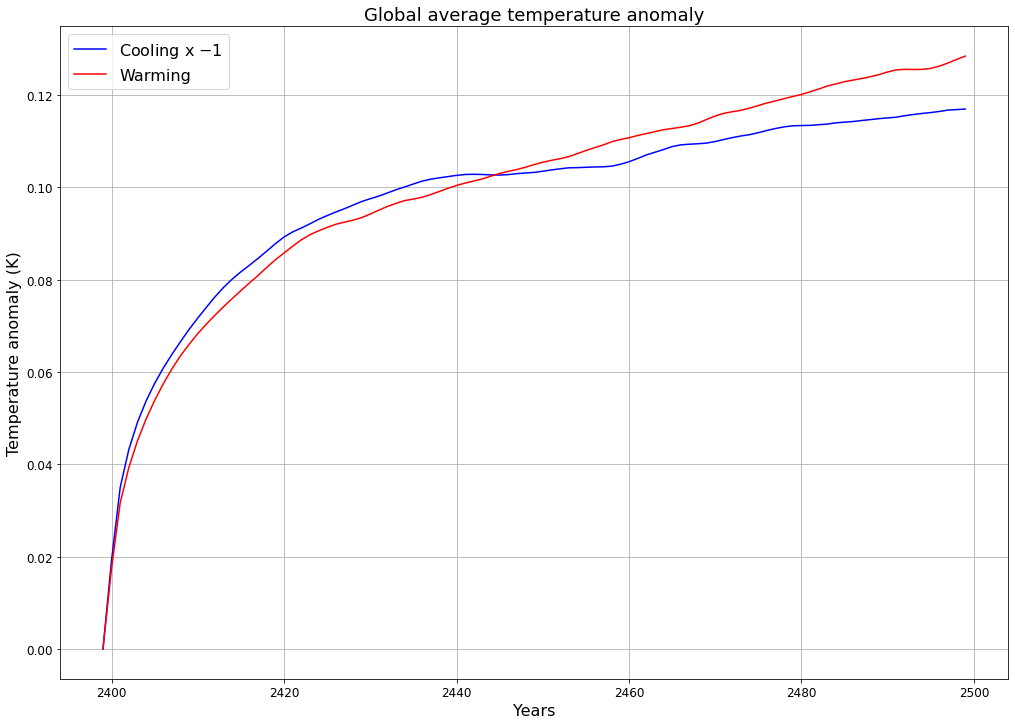

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [65]:
plt.figure(figsize = (17,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})
coolx1_anom_plot = xr.concat([zero, gat_cool - gat_cont], dim='year')
warmx1_anom_plot = xr.concat([zero, gat_warm - gat_cont], dim='year')
ave_anom_plot = xr.concat([zero, 0.5 * (-gat_cool + gat_warm)], dim='year')
diff_anom_plot = xr.concat([zero, (1 * (gat_cool - gat_cont) + (gat_warm - gat_cont))], dim='year')
#diff_anom_plot = xr.concat([zero, (1 * (gat_cool - gat_cont) + (gat_warm - gat_cont)) / (0.5 * (gat_cool + gat_warm - 2 * gat_cont)) ], dim='year')
# coolx2_anom_plot = xr.concat([zero, gat_cool_x2 - gat_cont], dim='year')
# warmx2_anom_plot = xr.concat([zero, gat_warm_x2 - gat_cont], dim='year')

# (- 0.5 * coolx2_anom_plot).plot(label='Double cooling x $-0.5$', color = 'b', linestyle='--')
(-1 * coolx1_anom_plot).plot(label='Cooling x $-1$', color = 'b')
warmx1_anom_plot.plot(label='Warming', color = 'r')
#ave_anom_plot.plot(label='Average anomaly', color = 'k', linestyle='--')
#diff_anom_plot.plot(label='Difference in anomalies', color = 'k', linestyle='-.')
# (0.5 * warmx2_anom_plot).plot(label='Double warming x $0.5$', color = 'r', linestyle='--')

plt.title('Global average temperature anomaly', fontsize=18)
plt.ylabel('Temperature anomaly (K)', fontsize=16)
plt.yticks(fontsize=12)
plt.xlabel('Years', fontsize=16)
plt.xticks(fontsize=12)
plt.legend(fontsize=16, loc='best')
plt.grid()
plt.savefig('ACCESS_gmt_step.jpg')

### Calculate SST

In [80]:
# SST
yr_beg = '2401-01-01' # I'm not sure why but this year makes the SST start at 2400-01-02, which I want.
expt = '1deg_jra55_ryf_cont'
var = 'temp_surface_ave'
SST_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg)[:-1].groupby('time.year').mean('time')

In [58]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp_surface_ave'
SST_RCPcool_humid_x1 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [61]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp_surface_ave'
SST_RCPwarm_humid_x1 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [59]:
expt = '1deg_jra55_ryf_RCPcool_humid_x2'
var = 'temp_surface_ave'
SST_RCPcool_humid_x2 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [ ]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
var = 'temp_surface_ave'
SST_RCPwarm_humid_x2 = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [56]:
expt = '1deg_jra55_ryf_warm_1.5sat_0dwlw_spinup500'
var = 'temp_surface_ave'
SST_warm_Tonly = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [57]:
expt = '1deg_jra55_ryf_warm_0sat_8dwlw_spinup500'
var = 'temp_surface_ave'
SST_warm_RADonly = cc.querying.getvar(expt, var, session)[:-1].groupby('time.year').mean('time')

In [17]:
SST_cont = SST_cont.load()
SST_step_test1 = SST_step_test1.load()
SST_step_test2 = SST_step_test2.load()

In [82]:
SST_cont = SST_cont.load()
SST_RCPcool_humid_x1 = SST_RCPcool_humid_x1.load()
SST_RCPwarm_humid_x1 = SST_RCPwarm_humid_x1.load()
# SST_RCPcool_humid_x2 = SST_RCPcool_humid_x2.load()
# SST_RCPwarm_humid_x2 = SST_RCPwarm_humid_x2.load()

# SST_coolx1 = SST_coolx1.load()
# SST_coolx2 = SST_coolx2.load()

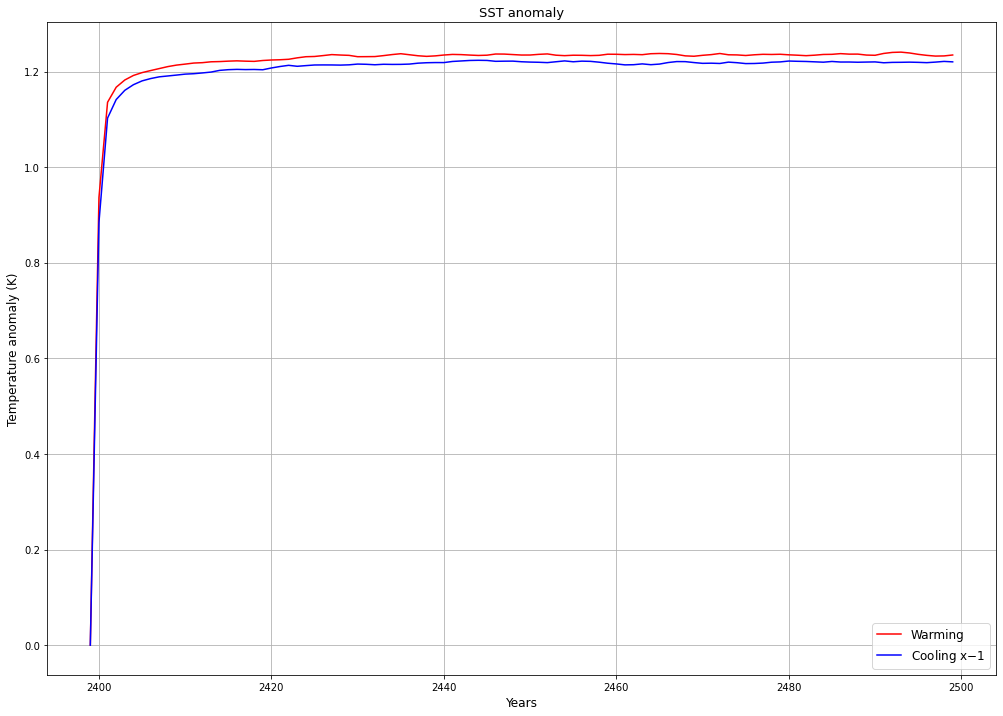

In [83]:
plt.figure(figsize = (17,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})

RCPcool_humid_x1_anom_plot = xr.concat([zero, SST_RCPcool_humid_x1[:,0] - SST_cont[:,0]], dim='year')
RCPwarm_humid_x1_anom_plot = xr.concat([zero, SST_RCPwarm_humid_x1[:,0] - SST_cont[:,0]], dim='year')
# RCPcool_humid_x2_anom_plot = xr.concat([zero, SST_RCPcool_humid_x2[:,0] - SST_cont[:,0]], dim='year')
# RCPwarm_humid_x2_anom_plot = xr.concat([zero, SST_RCPwarm_humid_x2[:,0] - SST_cont[:,0]], dim='year')

# (0.5 * RCPwarm_humid_x2_anom_plot).plot(label='Double warming x$0.5$', color = 'r', linestyle = '--')
RCPwarm_humid_x1_anom_plot.plot(label='Warming', color = 'r')
(- 1 * RCPcool_humid_x1_anom_plot).plot(label='Cooling x$-1$', color = 'b')
# (- 0.5 * RCPcool_humid_x2_anom_plot).plot(label='Double cooling x$-0.5$', color = 'b', linestyle = '--')

plt.title('SST anomaly', fontsize=13)
plt.ylabel('Temperature anomaly (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
#plt.savefig('SST_good_perturbation.jpg')

### Plot both SST and GAT

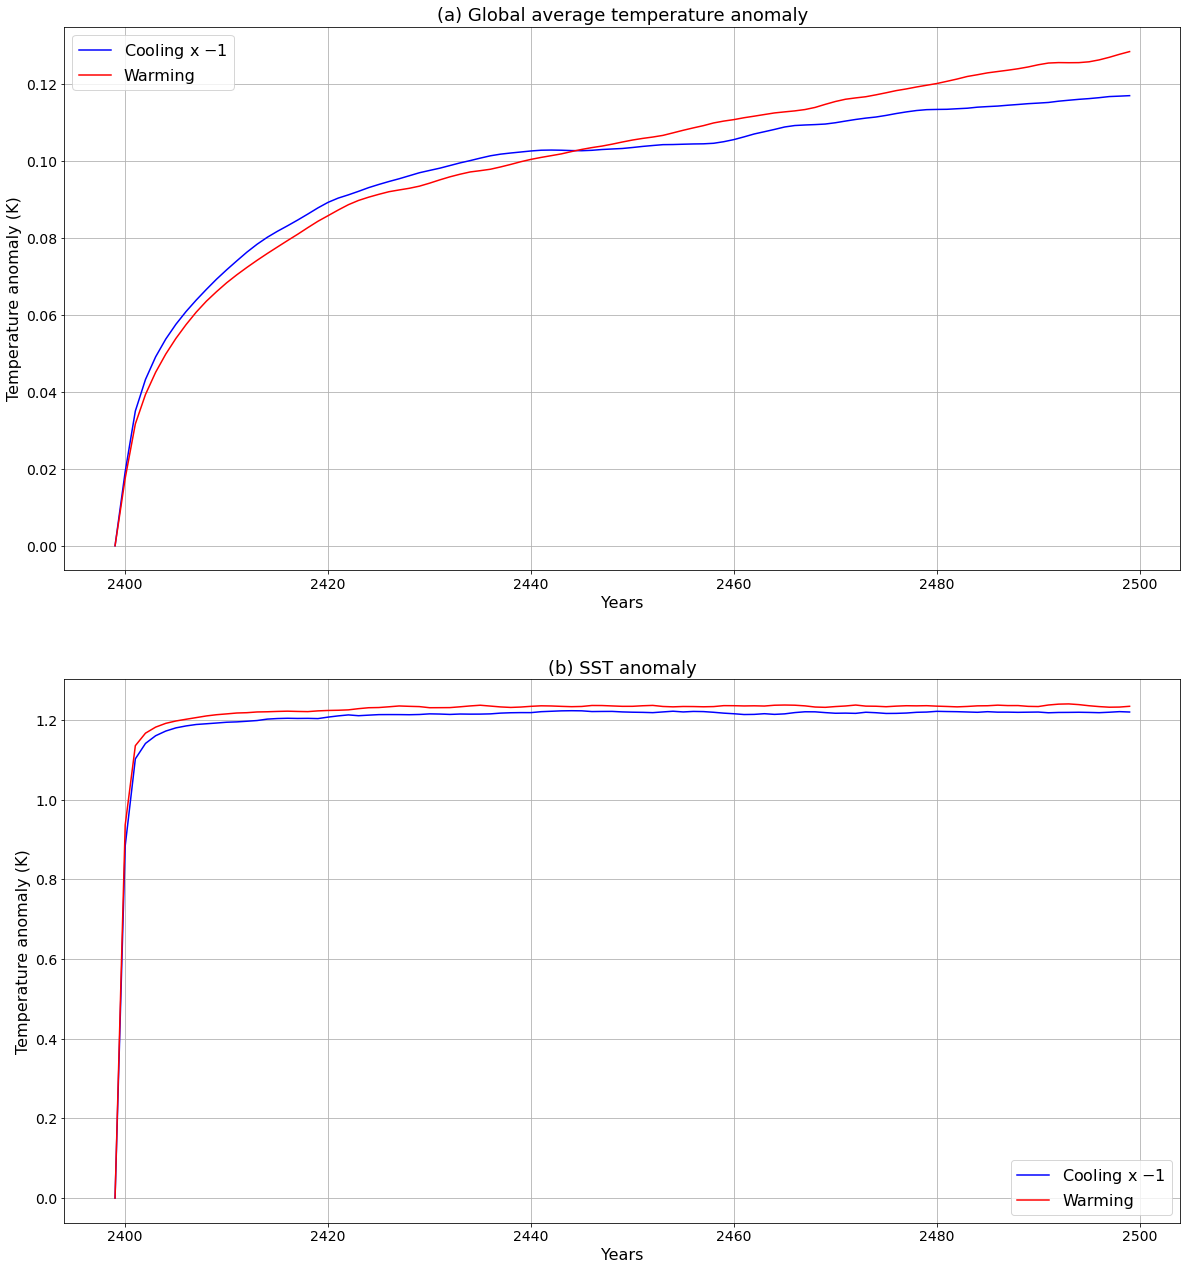

In [152]:
ncols = 1
nrows = 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize = (20,22))

ax = axs[0]
(-1 * coolx1_anom_plot).plot(ax=ax, label='Cooling x $-1$', color='b')
warmx1_anom_plot.plot(ax=ax, label='Warming', color='r')
ax.set_title('(a) Global average temperature anomaly', fontsize=18)
ax.set_ylabel('Temperature anomaly (K)', fontsize=16)
ax.set_xlabel('Years', fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=16, loc='best')
ax.grid()

ax = axs[1]
(-1 * RCPcool_humid_x1_anom_plot).plot(ax=ax, label='Cooling x $-1$', color='b')
RCPwarm_humid_x1_anom_plot.plot(ax=ax, label='Warming', color='r')
ax.set_title('(b) SST anomaly', fontsize=18)
ax.set_ylabel('Temperature anomaly (K)', fontsize=16)
ax.set_xlabel('Years', fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=16, loc='best')
ax.grid()

plt.savefig(f'gat_sst_anoms.jpg')

### Calculate horizontally-averaged temperature

In [10]:
def area_weighted_ave(tracer, expt):
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1).load() # area of cells
    area_total = area_t.sum(dim=('xt_ocean', 'yt_ocean')) # total area of ocean
    
    return (area_t * tracer).sum(dim=('xt_ocean', 'yt_ocean')) / area_total

In [11]:
temp_cool_horizontal_ave_anom = area_weighted_ave(temp_cool - temp_cont, '1deg_jra55_ryf_RCPcool_humid_x1').groupby('time.year').mean(dim='time').load()
temp_warm_horizontal_ave_anom = area_weighted_ave(temp_warm - temp_cont, '1deg_jra55_ryf_RCPwarm_humid_x1').groupby('time.year').mean(dim='time').load()

In [12]:
year_index = 2

largest_anom_difference_arg = np.where(-1 * temp_cool_horizontal_ave_anom.isel(year=year_index) - temp_warm_horizontal_ave_anom.isel(year=year_index) \
         == np.max(-1 * temp_cool_horizontal_ave_anom.isel(year=year_index) - temp_warm_horizontal_ave_anom.isel(year=year_index)))[0]

np.max(-1 * temp_cool_horizontal_ave_anom.isel(year=year_index) - temp_warm_horizontal_ave_anom.isel(year=year_index))
temp_warm_horizontal_ave_anom['st_ocean']
temp_warm_horizontal_ave_anom['st_ocean'][20]
(-1 * temp_cool_horizontal_ave_anom - temp_warm_horizontal_ave_anom).isel(year=year_index, st_ocean = 23)

<xarray.DataArray ()>
array(0.02376734, dtype=float32)
Coordinates:
    year      int64 2402
    st_ocean  float64 502.3

In [117]:
temp_cont_70s = temp_cont.groupby('time.year').mean(dim='time').sel(yt_ocean=-70, method='nearest').load()
temp_cool_70s = temp_cool.groupby('time.year').mean(dim='time').sel(yt_ocean=-70, method='nearest').load()
temp_warm_70s = temp_warm.groupby('time.year').mean(dim='time').sel(yt_ocean=-70, method='nearest').load()

In [13]:
# temp_cont_70s.sel(xt_ocean = xt_lon, method='nearest').isel(year=year_index).plot()

In [14]:
# plt.figure(figsize=(15,15))

# year_index = 2
# xt_lon = -40

# array = temp_warm_70s
# temps = (array.sel(xt_ocean = xt_lon, method='nearest').isel(year=year_index)).values - 273.15
# depths = (array.sel(xt_ocean = xt_lon, method='nearest').isel(year=year_index))['st_ocean'].values
# plt.plot(temps, depths)

# plt.title(f'Horizontally-averaged temperature anomaly at year {year_index}, lon = {xt_lon}', fontsize=20)
# plt.ylabel('Depth (m)', fontsize=15)
# plt.xlabel('Temperature ($\degree$C)', fontsize=15)
# plt.grid()
# plt.gca().invert_yaxis()

# #plt.savefig(f'vertical_temperature_anom_year{year_index}.jpg')

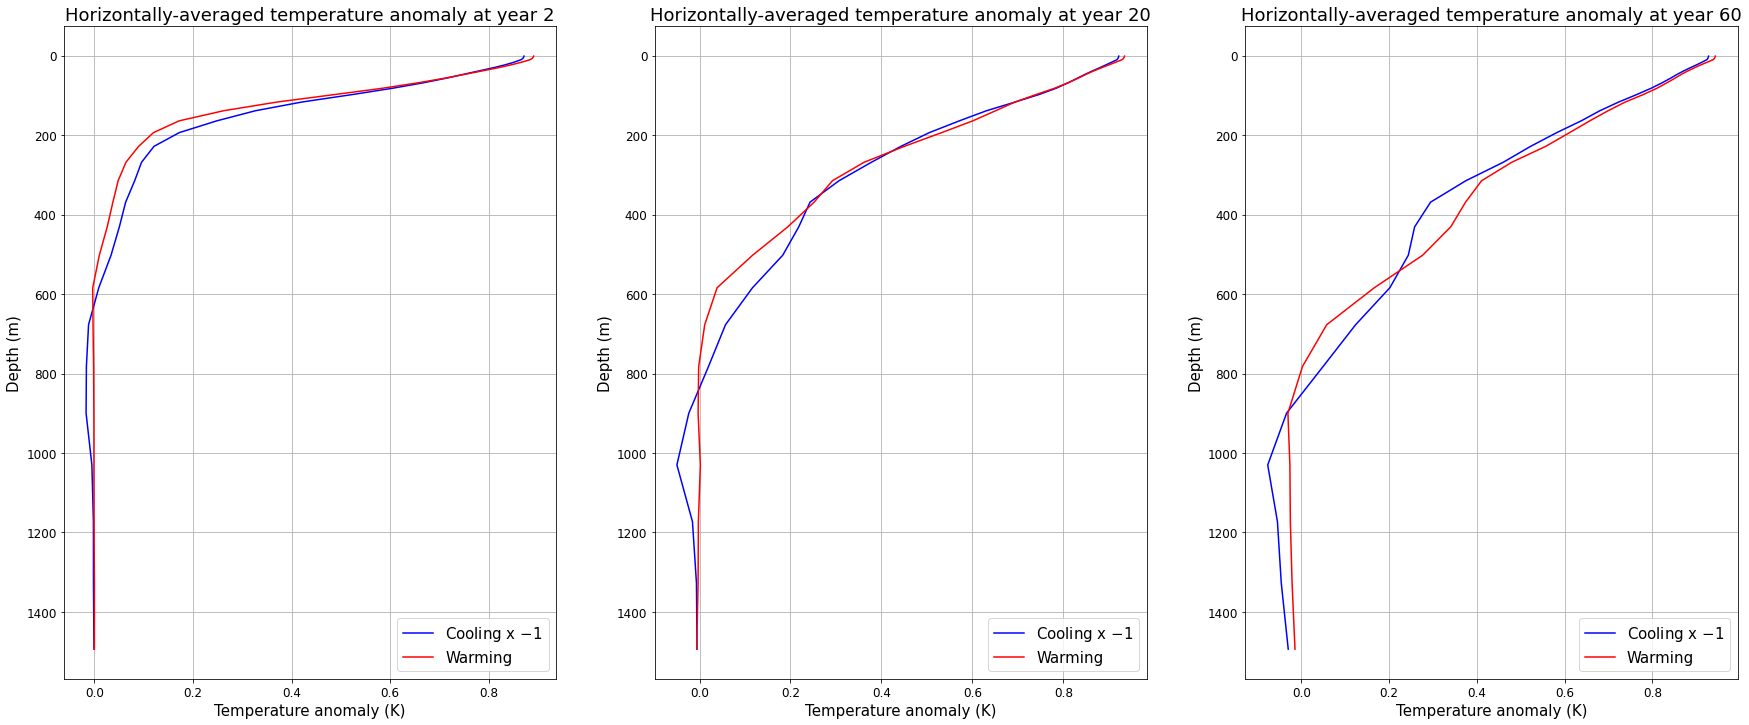

In [15]:
ncols = 3
nrows = 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize = (30,12))

years = 2400 + np.array([2, 20, 60]) 

for i in range(ncols):
    simulation_year = years[i] - 2400
    axs[i].plot(-1 * temp_cool_horizontal_ave_anom.sel(year=years[i]).sel(st_ocean=slice(None, 1600)).values, temp_cool_horizontal_ave_anom.sel(st_ocean=slice(None, 1600))['st_ocean'], label='Cooling x $-1$', color = 'b')
    axs[i].plot(temp_warm_horizontal_ave_anom.sel(year=years[i]).sel(st_ocean=slice(None, 1600)).values, temp_warm_horizontal_ave_anom.sel(st_ocean=slice(None, 1600))['st_ocean'], label='Warming', color = 'r')
    axs[i].set_title(f'Horizontally-averaged temperature anomaly at year {simulation_year}', fontsize=18)
    axs[i].set_ylabel('Depth (m)', fontsize=15)
    axs[i].set_xlabel('Temperature anomaly (K)', fontsize=15)
    axs[i].tick_params(labelsize=12)
    axs[i].legend(fontsize=15, loc='lower right')
    axs[i].grid()
    axs[i].invert_yaxis()

# plt.savefig(f'vertical_temperature_anoms.jpg')